In [1]:
import numpy as np
import igl
import math
import matplotlib.pyplot as plt
import matplotlib.colors
import mpl_toolkits.mplot3d 
from icosphere import icosphere
import plotly.graph_objects as go
import os


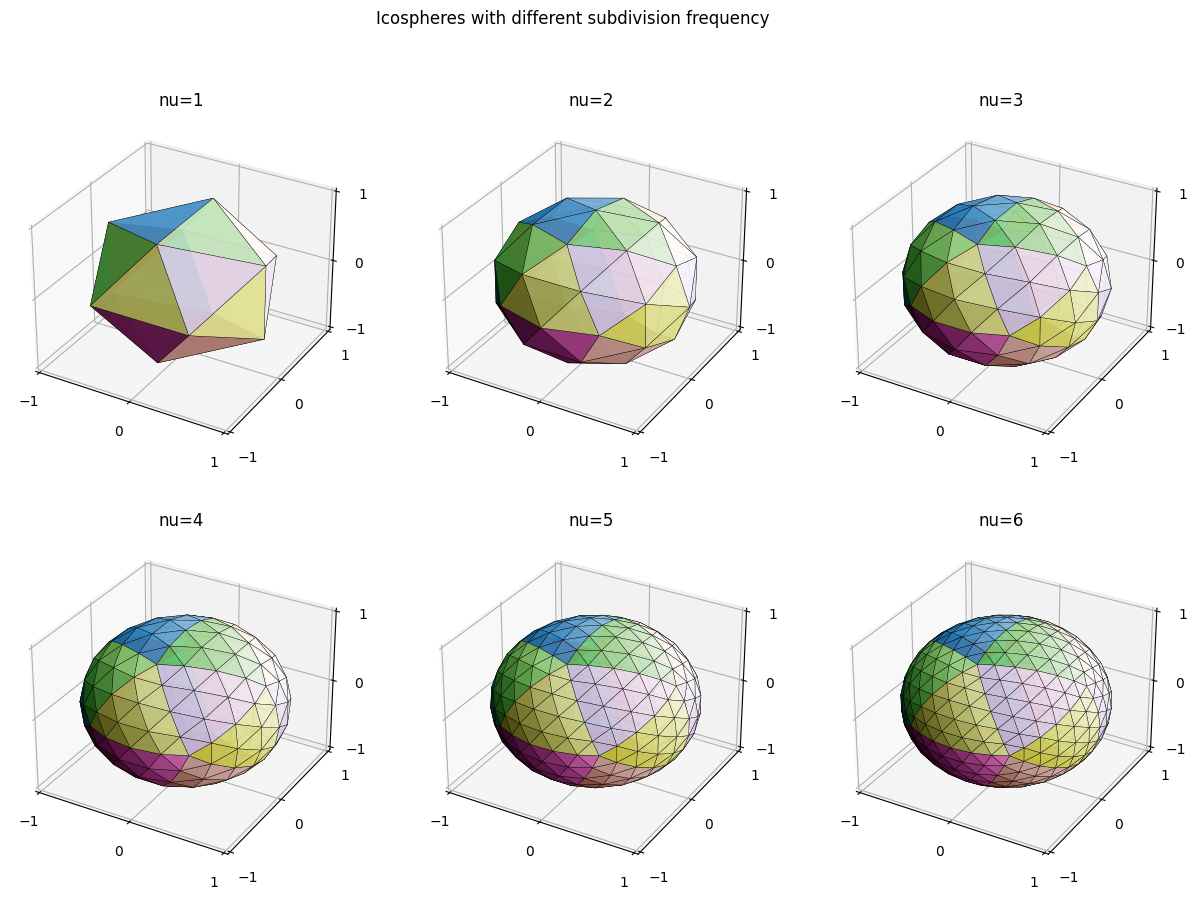

In [2]:
# source: https://github.com/vedranaa/icosphere/blob/main/Example_in_matplotlib.ipynb

fig = plt.figure(figsize=(15, 10))
for nu in range(1,7):

    vertices, faces = icosphere(nu=nu)
    
    # basic mesh color, divided in 20 groups (one for each original face)
    jet = matplotlib.cm.tab20(np.linspace(0,1,20))
    jet = np.tile(jet[:,:3], (1, faces.shape[0]//20))
    jet = jet.reshape(faces.shape[0], 1, 3)

    # computing face shading intensity based on face normals  
    face_normals = np.cross(vertices[faces[:,1]]-vertices[faces[:,0]], 
                            vertices[faces[:,2]]-vertices[faces[:,0]])
    face_normals /= np.sqrt(np.sum(face_normals**2, axis=1, keepdims=True))               
    light_source = matplotlib.colors.LightSource(azdeg=60, altdeg=30)
    intensity = light_source.shade_normals(face_normals)

    # blending face colors and face shading intensity
    rgb = light_source.blend_hsv(rgb=jet, intensity=intensity.reshape(-1,1,1))   

    # adding alpha value, may be left out
    rgba = np.concatenate((rgb, 0.9*np.ones(shape=(rgb.shape[0],1,1))), axis=2) 

    # creating mesh with given face colors
    poly = mpl_toolkits.mplot3d.art3d.Poly3DCollection(vertices[faces])
    poly.set_facecolor(rgba.reshape(-1,4)) 
    poly.set_edgecolor('black')
    poly.set_linewidth(0.25)

    # and now -- visualization!
    ax = fig.add_subplot(2, 3, nu, projection='3d')  

    ax.add_collection3d(poly) 
        
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)
    
    ax.set_xticks([-1,0,1])
    ax.set_yticks([-1,0,1])
    ax.set_zticks([-1,0,1])
    
    ax.set_title(f'nu={nu}')

fig.suptitle('Icospheres with different subdivision frequency')
plt.show()

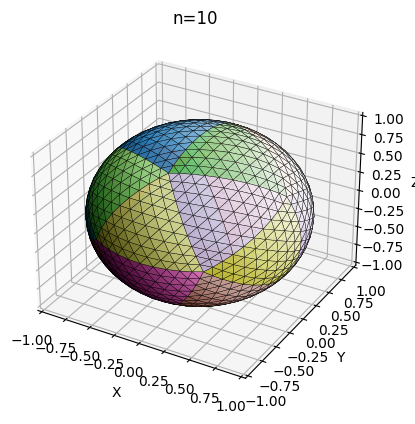

In [3]:
nu = 10
vertices, faces = icosphere(nu)

# basic mesh color, divided in 20 groups (one for each original face)
jet = matplotlib.cm.tab20(np.linspace(0,1,20))
jet = np.tile(jet[:,:3], (1, faces.shape[0]//20))
jet = jet.reshape(faces.shape[0], 1, 3)

# computing face shading intensity based on face normals  
face_normals = np.cross(vertices[faces[:,1]]-vertices[faces[:,0]], 
                        vertices[faces[:,2]]-vertices[faces[:,0]])
face_normals /= np.sqrt(np.sum(face_normals**2, axis=1, keepdims=True))               
light_source = matplotlib.colors.LightSource(azdeg=60, altdeg=30)
intensity = light_source.shade_normals(face_normals)

# blending face colors and face shading intensity
rgb = light_source.blend_hsv(rgb=jet, intensity=intensity.reshape(-1,1,1))   

# adding alpha value, may be left out
rgba = np.concatenate((rgb, 0.9*np.ones(shape=(rgb.shape[0],1,1))), axis=2) 

# creating mesh with given face colors
poly = mpl_toolkits.mplot3d.art3d.Poly3DCollection(vertices[faces])
poly.set_facecolor(rgba.reshape(-1,4)) 
poly.set_edgecolor('black')
poly.set_linewidth(0.25)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  

ax.add_collection3d(poly) 

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'n={nu}')
plt.show()

In [4]:
# Geodetic distance between two points 
print(vertices.shape, faces.shape)

vertices = vertices.astype(float)
faces = faces.astype(int)

vs, vt = np.random.randint(0, len(vertices), 2)
# fs, ft = np.random.randint(0, len(faces), 2)

fs, ft = 750, 890
vs, vt, fs, ft = np.array([vs]), np.array([vt]), np.array([fs]), np.array([ft])

# finding the shortest path between the two points
dist = igl.exact_geodesic(vertices, faces, vs, vt)
# dist = igl.exact_geodesic(vertices, faces, fs, ft)
# print(fs, ft)
# print(dist)

(1002, 3) (2000, 3)


In [5]:
#Projecting the point on the mesh
def project_point_to_mesh(point, vecs):
    v1 = vecs[1] - vecs[0]
    v2 = vecs[2] - vecs[0]
    
    normal = np.cross(v1, v2) # Calculate the normal vector of the plane
    v = point - vecs[0] # Calculate direction vector of the point to the plane
    vl = np.dot(v, normal) # Calculate the length of the projection vector
    nl = np.dot(normal, normal) # Calculate the length of the normal vector
    y = point - vl / nl * normal # Calculate the projection point

    return y

def shortest_path(vecs, faces, vs, vt):

    shortest_path = math.inf

    # get the indices and coordinates of the closest vertices to the source and target points
    ds = igl.point_mesh_squared_distance(vs, vecs, faces)
    svec = faces[ds[1]]
    svec_coords = vecs[svec]
    dt = igl.point_mesh_squared_distance(vt, vecs, faces)
    tvec = faces[dt[1]]
    tvec_coords = vecs[tvec]

    # find the shortest path between the source and target points
    vs = project_point_to_mesh(vs, svec_coords).astype(float) # project the source point on the mesh
    dist_vs_vecs = np.linalg.norm(vs-svec_coords, axis=1) # distance between the source point and the closest vertices
    # print(dist_vs_vecs)
    vt = project_point_to_mesh(vt, tvec_coords).astype(float) # project the target point on the mesh
    dist_vt_vecs = np.linalg.norm(vt-tvec_coords, axis=1) # distance between the target point and the closest vertices
    # print(dist_vt_vecs)
    dist_vecs = igl.exact_geodesic(vecs, faces, svec, tvec) # distance between the closest vertices
    dist = dist_vs_vecs + dist_vecs + dist_vt_vecs # total distance
    shortest_path = np.min(dist)
    
    return shortest_path

def pair_distance_mesh(vecs, faces, samples):
    npts = np.shape(samples)[0]
    dist = []
    for i in range(npts):
        for j in range(i+1, npts):
            # reshape to (1,3) array
            vs = samples[i].reshape(1,3)
            vt = samples[j].reshape(1,3)
            d = shortest_path(vecs, faces, vs, vt)
            dist.append(d)
    return dist

In [6]:
def mesh_area(vecs, faces):
    double_areas = igl.doublearea(vecs, faces)
    surface_area = np.sum(double_areas) / 2.0
    return surface_area

def ripleyK_mesh(vecs, faces, data, radii):
    K = np.zeros_like(radii)
    area = mesh_area(vecs, faces)
    dists = pair_distance_mesh(vecs, faces, data)
    pair_num = len(dists)
    intensity = pair_num / area
    for i in range(len(radii)):
        K[i] = np.sum(dists < radii[i])
    K = K / intensity
    return K

In [7]:
# distance between two points on a sphere 
# https://www.cuemath.com/trigonometry/trigonometric-table/
# Source: https://www.math.ksu.edu/~dbski/writings/haversine.pdf

def distance(r,vec1,vec2):
    # pythagorean theorem
    d = np.linalg.norm(vec1-vec2)
    # Arc Distance
    dist = r * 2 * math.asin(d/2)
    return dist

def pairDistances(r, data):
    npts = np.shape(data)[0]
    dist = []
    for i in range(npts):
        for j in range(i+1, npts):
            #dist.append(distance(r, data[i, 0], data[i, 1], data[i, 2], data[j, 0], data[j, 1], data[j, 2]))
            dist.append(distance(r, data[i], data[j]))
    return dist

# Calculating the distance between all pairs of points
def surfaceArea(r):
    area = 4 * math.pi * r**2
    return area


def ripleyK(r, data, radii):
    K = np.zeros_like(radii)
    area = surfaceArea(r)
    dist = pairDistances(r, data)
    pair_num = len(dist)
    intensity = pair_num / area
    for i in range(len(radii)):
        K[i] = np.sum(dist < radii[i])
    K = K / intensity
    return K

In [8]:
def samples_uniform_sphere(n):
    # Generating z coordinates with radius = 1
    z = np.random.uniform(-1,1,n)

    # Generating azimuthal angles
    phi = np.random.uniform(0,2*math.pi,n)

    # Generating x and y coordinates
    x = np.sqrt(1-z**2)*np.cos(phi)
    y = np.sqrt(1-z**2)*np.sin(phi)
    samples = np.array([x,y,z]).T
    return samples

In [9]:
def sample_faces(vertices, faces, num_samples):
    # calculate the area of each triangle
    a = vertices[faces[:, 0]]
    b = vertices[faces[:, 1]]
    c = vertices[faces[:, 2]]
    areas = np.linalg.norm(np.cross(b-a, c-a), axis=1) / 2

    # normalize areas to get probability distribution
    probabilities = areas / np.sum(areas)

    # randomly choose triangles to sample from
    face_indices = np.random.choice(len(faces), size=num_samples, p=probabilities)

    # generate random points within each selected triangle
    u = np.random.rand(num_samples, 1)
    v = np.random.rand(num_samples, 1)
    w = 1 - u - v
    a = vertices[faces[face_indices, 0]]
    b = vertices[faces[face_indices, 1]]
    c = vertices[faces[face_indices, 2]]
    points = u * a + v * b + w * c

    return points

In [10]:
points = sample_faces(vertices, faces, 100)
points_uniform = samples_uniform_sphere(100)

x, y, z = vertices.T
i, j, k = faces.T

fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, color='cyan', opacity=0.50)])
fig.add_trace(go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=2, color='red')))
fig.show()

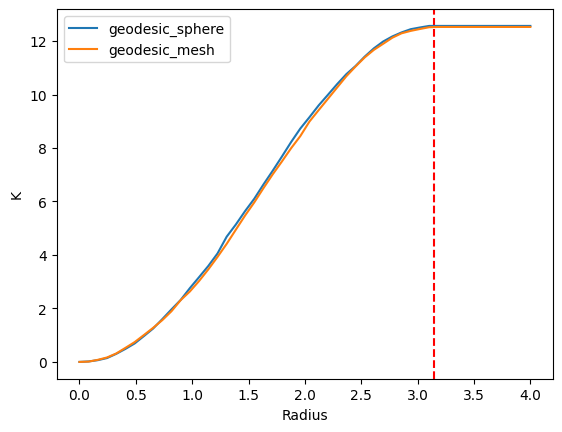

In [11]:
radii = np.linspace(0, 4, 50)

# area_mesh = mesh_area(vertices, faces)
# area_sphere = surfaceArea(1)
# print('Area of the mesh: ', area_mesh)
# print('Area of the sphere: ', area_sphere)


# dist_mesh = shortest_path(vertices, faces, np.array(points[0]).reshape(1,3), np.array(points[1]).reshape(1,3))
# dist = distance(1, points[0], points[1])

# print('Distance between two points on the mesh: ', dist_mesh)
# print('Distance between two points on the sphere: ', dist)

# pair_distance_mesh = pair_distance(vertices, faces, points)
# pair_distance_sphere = pairDistances(1, points)

# print('Distance between all pairs of points on the mesh: ', pair_distance_mesh)
# print('Distance between all pairs of points on the sphere: ', pair_distance_sphere)


kt = ripleyK(1, points_uniform, radii)
kt_mesh = ripleyK_mesh(vertices, faces, points, radii)

# print('Ripley''s K function for a sphere: ', kt)
# print('Ripley''s K function for a mesh: ', kt_mesh)

# Plotting the Ripley's K function

plt.axvline(x=math.pi, color='r', linestyle='--')
plt.plot(radii, kt, label='geodesic_sphere')
plt.plot(radii, kt_mesh, label='geodesic_mesh')
plt.xlabel('Radius')
plt.ylabel('K')
plt.legend()
plt.show()

In [12]:
current_dir = os.getcwd()

vertices, faces = igl.read_triangle_mesh(os.path.join(current_dir, "mesh", "torus-100-3-.25.obj"))

# sampling points on the mesh
samples_mesh = sample_faces(vertices, faces, 100)

print('Samples on the mesh: ', samples_mesh.shape)


x, y, z = vertices.T
i, j, k = faces.T

lines= go.Scatter3d(x=x, y=y, z=z, mode='lines', line=dict(color= 'black', width=1.0))
fig1 = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, 
                                i=i, j=j, k=k, 
                                colorscale = [[0, 'cyan'],
                                            [1, 'yellow']],
                                intensity = z,
                                opacity=0.50,
                                showscale=True)])
fig1.add_trace(go.Scatter3d(x=samples_mesh[:,0], y=samples_mesh[:,1], z=samples_mesh[:,2], mode='markers', marker=dict(size=3, color='red')))
fig1.add_trace(lines)
fig1.show()

Samples on the mesh:  (100, 3)


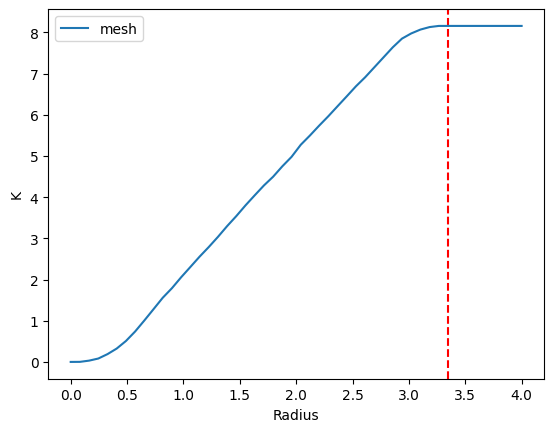

In [13]:
kt_mesh = ripleyK_mesh(vertices, faces, samples_mesh, radii)

# Plotting the Ripley's K function
plt.axvline(x=3.35, color='r', linestyle='--')
plt.plot(radii, kt_mesh, label='mesh')
plt.xlabel('Radius')
plt.ylabel('K')
plt.legend()
plt.show()